In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_data = dsets.MNIST(root='data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

test_data = dsets.MNIST(root='data/',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

In [5]:
batch_size = 100

train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=False)

test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)

In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

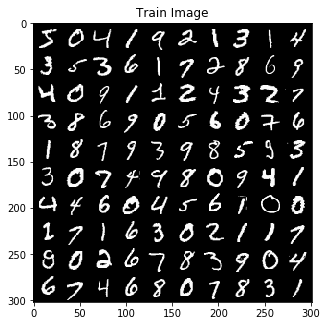

In [9]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True, nrow=10), "Train Image")

In [11]:
labels.view(-1,10)

tensor([[5, 0, 4, 1, 9, 2, 1, 3, 1, 4],
        [3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
        [4, 0, 9, 1, 1, 2, 4, 3, 2, 7],
        [3, 8, 6, 9, 0, 5, 6, 0, 7, 6],
        [1, 8, 7, 9, 3, 9, 8, 5, 9, 3],
        [3, 0, 7, 4, 9, 8, 0, 9, 4, 1],
        [4, 4, 6, 0, 4, 5, 6, 1, 0, 0],
        [1, 7, 1, 6, 3, 0, 2, 1, 1, 7],
        [9, 0, 2, 6, 7, 8, 3, 9, 0, 4],
        [6, 7, 4, 6, 8, 0, 7, 8, 3, 1]])

## Model

In [12]:
##nn.Sequential내 에서는 형태 변화가 불가하기 때문에 class로 선언
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1,16,5), #1채널을 16채널로, 필터 5 = 24*24*16 / 가중치 25*16
            nn.ReLU(), #Activation
            nn.Conv2d(16,32,5), #16채널은 32채널로, 필터 5 = 20*20*32 / 가중치 25*32
            nn.ReLU(),
            nn.MaxPool2d(2,2), #2배 감소
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #2배 감소
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100), #conv_layer의 결과
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*3*3)
        out = self.fc_layer(out)
        
        return out

In [13]:
model = CNN().cuda() #GPU

In [14]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train

In [15]:
num_epochs = 3

In [18]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.cuda() #GPU
        Y = batch_labels.cuda() #GPU

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/3], lter [300/600], Loss: 0.0139
Epoch [1/3], lter [600/600], Loss: 0.2648
Epoch [2/3], lter [300/600], Loss: 0.0083
Epoch [2/3], lter [600/600], Loss: 0.2629
Epoch [3/3], lter [300/600], Loss: 0.0116
Epoch [3/3], lter [600/600], Loss: 0.2395


In [19]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 99.040000 %
